In [1]:
#!pip install wordcloud

In [2]:
import pandas as pd
import unicodedata
import re
import contractions
import string

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random
sns.set() 

#spacy
import spacy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
nltk.download('wordnet')
from nltk.corpus import stopwords 
import textwrap
stops = stopwords.words('english')
stops += ['use', 'using', 'used', 'part']
from wordcloud import WordCloud



/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages

In [3]:
def load_data():   #load the data 
    df_all = pd.read_csv('Created_Cases - databricks.csv')
    # Take a subset
    return df_all.loc[:, ["Case title","Session Id","Email Id","Date Time"]]
data = load_data()
data.rename(
    columns=({ 'Case title': 'Case_title', 'Session Id': 'Session_Id','Date Time':'Date_Time','Email Id':'Email_Id'}), 
    inplace=True
)
data.head()

,Case_title,Session_Id,Email_Id,Date_Time
0,genie,1654038670643245,NaN,2022-05-31T23:58:12.000Z
1,genie,1654040144291671,NaN,2022-05-31T23:38:03.000Z
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31T23:30:57.000Z
3,Union with Null,1654032363233406,NaN,2022-05-31T21:31:24.000Z
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31T21:27:16.000Z


# Use the Email module to extract raw text

In [4]:
data['User'] = data['Email_Id'].str.split("@").str[0]    #Extract user name from the emails 
data.head()

,Case_title,Session_Id,Email_Id,Date_Time,User
0,genie,1654038670643245,NaN,2022-05-31T23:58:12.000Z,NaN
1,genie,1654040144291671,NaN,2022-05-31T23:38:03.000Z,NaN
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31T23:30:57.000Z,NaN
3,Union with Null,1654032363233406,NaN,2022-05-31T21:31:24.000Z,NaN
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31T21:27:16.000Z,NaN


In [5]:
odd_date = '2022-05-31T23:58:12.000Z'

In [6]:
data['Date_Time'] = data['Date_Time'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y-%m-%dT%H:%M:%S.000Z' ))

In [7]:
data.head()

,Case_title,Session_Id,Email_Id,Date_Time,User
0,genie,1654038670643245,NaN,2022-05-31 23:58:12,NaN
1,genie,1654040144291671,NaN,2022-05-31 23:38:03,NaN
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31 23:30:57,NaN
3,Union with Null,1654032363233406,NaN,2022-05-31 21:31:24,NaN
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31 21:27:16,NaN


In [8]:
df = data.copy()

In [9]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], infer_datetime_format=True)
df.head()
df.dtypes

Case_title            object
Session_Id             int64
Email_Id              object
Date_Time     datetime64[ns]
User                  object
dtype: object

In [10]:
df['Date'] = df['Date_Time'].dt.normalize()

In [11]:
df.head()

,Case_title,Session_Id,Email_Id,Date_Time,User,Date
0,genie,1654038670643245,NaN,2022-05-31 23:58:12,NaN,2022-05-31
1,genie,1654040144291671,NaN,2022-05-31 23:38:03,NaN,2022-05-31
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31 23:30:57,NaN,2022-05-31
3,Union with Null,1654032363233406,NaN,2022-05-31 21:31:24,NaN,2022-05-31
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31 21:27:16,NaN,2022-05-31


In [12]:
df['MonthNum'] = df['Date_Time'].dt.month
df['DayOfMonth'] = df['Date_Time'].dt.day
df['Year'] = df['Date_Time'].dt.year
df['Day'] = df['Date_Time'].dt.dayofweek


In [13]:
df.head()

,Case_title,Session_Id,Email_Id,Date_Time,User,Date,MonthNum,DayOfMonth,Year,Day
0,genie,1654038670643245,NaN,2022-05-31 23:58:12,NaN,2022-05-31,5,31,2022,1
1,genie,1654040144291671,NaN,2022-05-31 23:38:03,NaN,2022-05-31,5,31,2022,1
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31 23:30:57,NaN,2022-05-31,5,31,2022,1
3,Union with Null,1654032363233406,NaN,2022-05-31 21:31:24,NaN,2022-05-31,5,31,2022,1
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31 21:27:16,NaN,2022-05-31,5,31,2022,1


In [14]:
df['User'].isnull().value_counts()

False    6074
True     1535
Name: User, dtype: int64

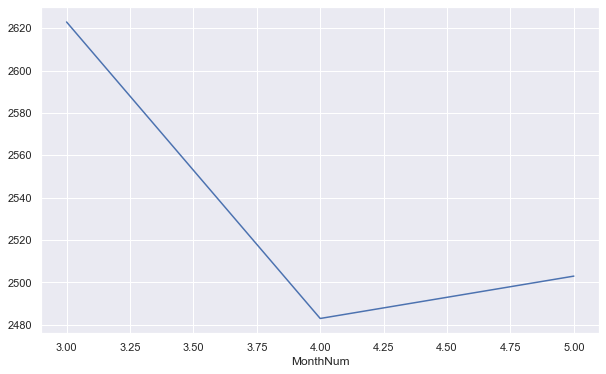

In [15]:
plt.figure(figsize = (10,6))
figure2 = df.groupby('MonthNum')['Case_title'].count().plot()

# Users and number of emails they sent by year

In [16]:
df.groupby(['User', 'MonthNum'])['Case_title'].count()

User                                     MonthNum
2d847468.nipponpaintcom.onmicrosoft.com  4            1
aarjoh                                   3            1
aashokkumar1                             3            1
abhard04                                 3           13
                                         4            7
                                                     ..
zhiyunluo                                4           31
                                         5           20
zi.gao                                   5            1
zkorelic                                 4            1
zlevow                                   3            1
Name: Case_title, Length: 1770, dtype: int64

# TOP 10 FREQUENT USERS

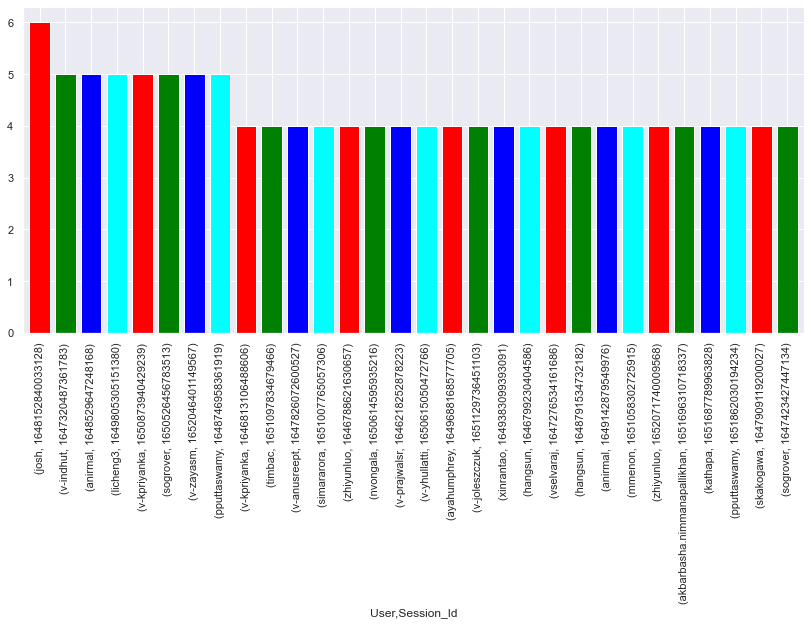

In [17]:
def top_ten():   
    top_10_frequent = df.groupby(['User','Session_Id'])['Case_title'].count().sort_values(ascending = False)[:30]
    plt.figure(figsize = (14,6))
    top_10_frequent.plot(kind = 'bar',color=['red', 'green', 'blue', 'cyan'],width = 0.8)
top_ten()

In [18]:
df.head()

,Case_title,Session_Id,Email_Id,Date_Time,User,Date,MonthNum,DayOfMonth,Year,Day
0,genie,1654038670643245,NaN,2022-05-31 23:58:12,NaN,2022-05-31,5,31,2022,1
1,genie,1654040144291671,NaN,2022-05-31 23:38:03,NaN,2022-05-31,5,31,2022,1
2,jproperties library installation issue,1654038759243102,NaN,2022-05-31 23:30:57,NaN,2022-05-31,5,31,2022,1
3,Union with Null,1654032363233406,NaN,2022-05-31 21:31:24,NaN,2022-05-31,5,31,2022,1
4,Spark ReadStream fails to infer schema,1654030825979675,NaN,2022-05-31 21:27:16,NaN,2022-05-31,5,31,2022,1


In [19]:
df4 = df[['Case_title','Session_Id','MonthNum']]
df4.head()

,Case_title,Session_Id,MonthNum
0,genie,1654038670643245,5
1,genie,1654040144291671,5
2,jproperties library installation issue,1654038759243102,5
3,Union with Null,1654032363233406,5
4,Spark ReadStream fails to infer schema,1654030825979675,5


# Duplicate Tickets for last 3 months 

<AxesSubplot:title={'center':'Duplicate tickets'}, xlabel='MonthNum,None'>

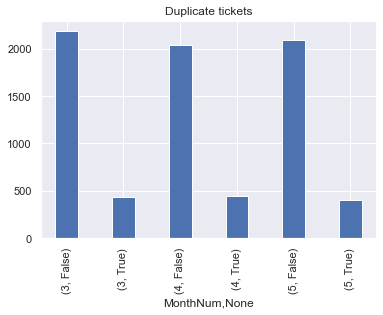

In [20]:
df4[['Case_title']].duplicated().groupby(df4['MonthNum']).value_counts().plot(kind='bar',stacked=True, title = "Duplicate tickets",width=0.4)

In [21]:
ll = [x for x in df4['Case_title'] if ("Genie" not in x) and ("genie" not in x) ]
len(ll)

5605

In [22]:
d8 = pd.DataFrame(ll)
d8.rename(columns = {0: "title"},inplace=True)
len(d8)

5605

In [23]:
d8['title'].nunique()

5214

In [24]:
d8.to_csv('databricks2.csv')

In [25]:
text = d8['title'].to_string()

In [26]:
type(text)

str

# WORD CLOUD

In [27]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

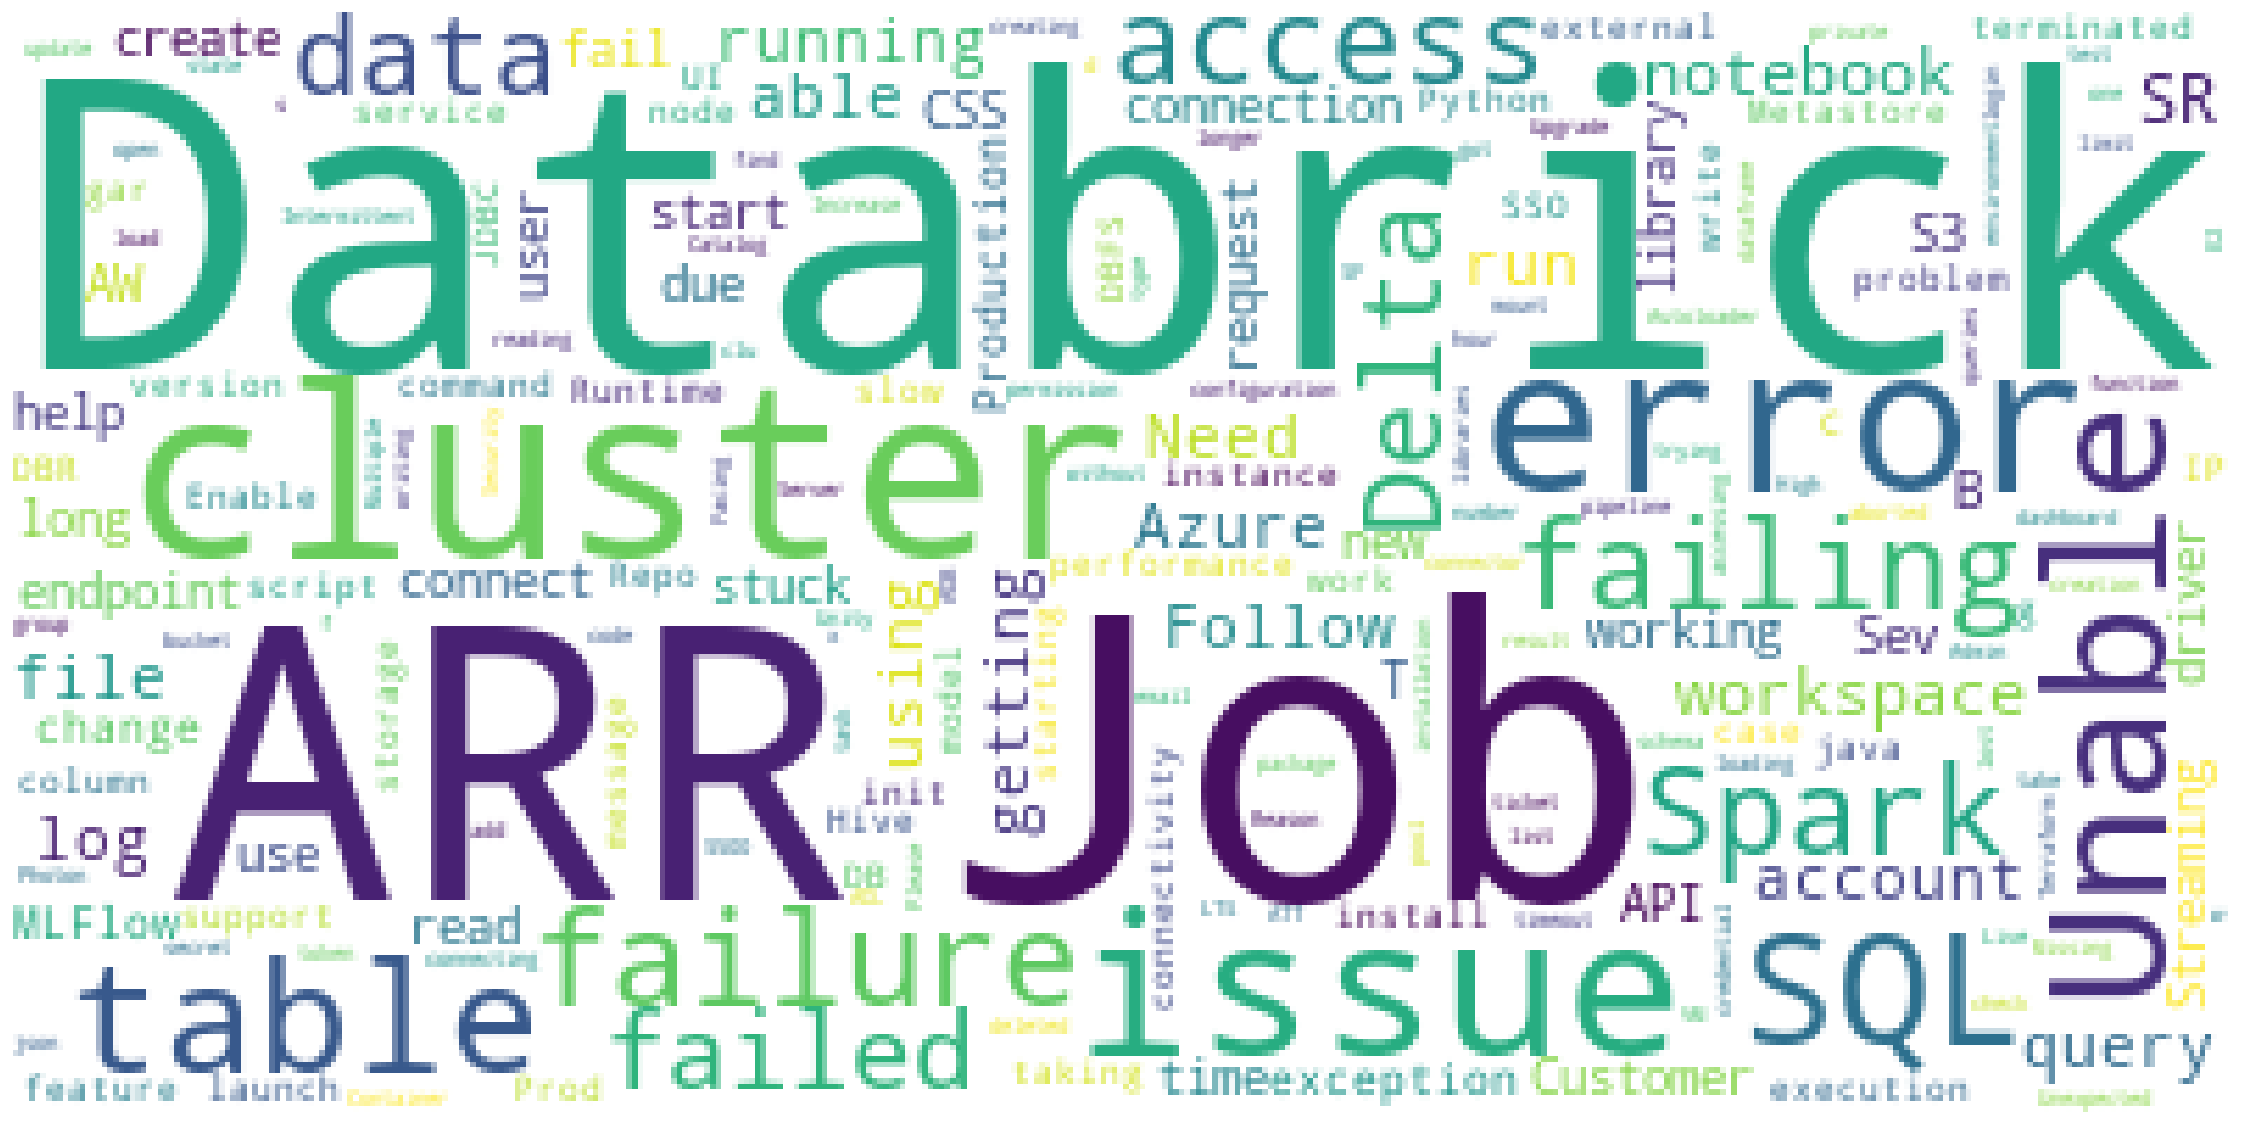

In [28]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
plot_cloud(word_cloud)    

In [29]:
(df4[['Case_title']].duplicated().groupby(df4['MonthNum'] ==3).value_counts())


MonthNum       
False     False    4137
          True      849
True      False    2189
          True      434
dtype: int64

In [30]:
pd.DataFrame

pandas.core.frame.DataFrame

In [31]:
df4[['Case_title']].duplicated().groupby(df4['MonthNum']).value_counts()

MonthNum       
3         False    2189
          True      434
4         False    2041
          True      442
5         False    2096
          True      407
dtype: int64

In [32]:
mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
grouped_df = df4.loc[df.MonthNum ==5].groupby(df4['Session_Id']).agg({'Case_title':list})
# Join all queries in a cases
grouped_df['Case_title'] = grouped_df['Case_title'].apply(lambda x: ' '.join(x))
# Create a list of grouped queries
# for each title. 
queries = list(grouped_df['Case_title'])
grouped_df[:10]
len(grouped_df)

2145

# TF-IDF tranformation for K-means algorithm

In [33]:
vec = TfidfVectorizer(stop_words='english')
%time X = vec.fit_transform(queries)
tf_idf_norm = normalize(X)
tf_idf_array = tf_idf_norm.toarray()
#pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()
 
pd.DataFrame(
    tf_idf_array,
    #columns=tf_idf_vectorizor.get_feature_names()
).head()
print(X.shape)

CPU times: user 26.7 ms, sys: 2.98 ms, total: 29.7 ms
Wall time: 34.7 ms
(2145, 2895)


In [34]:
terms = vec.get_feature_names()
terms[:10]

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00122446',
 '00128160',
 '00133177',
 '00138037',
 '00138590',
 '00138914',
 '00138978',
 '00139396',
 '00140194',
 '00140430']

# K-means clustering
Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. K-means initializes with a pre-determined number of clusters (here 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

In [36]:
from sklearn.cluster import KMeans

num_clusters = 140

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()

CPU times: user 14.8 s, sys: 658 ms, total: 15.4 s
Wall time: 2.6 s


In [37]:
import joblib

#joblib.dump(km,  'doc_cluster.pkl')
clusters = km.labels_.tolist()

In [38]:
ranks = []

for i in range(0,len(grouped_df['Case_title'])):
    ranks.append(i)

In [39]:
ranks[:10]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [40]:
import pandas as pd

films = { 'title': queries, 'rank':ranks, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['title','rank', 'cluster'])
frame

,title,rank,cluster
3,Genie,0,3
0,Gnie,1,0
0,2204290030000540,2,0
124,ARR - Sev A - Databricks notebook is stuck,3,124
18,genie access,4,18
...,...,...,...
2,Genie access Request,2140,2
0,Union with Null,2141,0
3,genie,2142,3
65,jproperties library installation issue,2143,65


In [41]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0      1057.687500
1      1061.437500
2      1249.245283
3      1026.340580
4      1199.000000
          ...     
135    1085.900000
136    1046.470588
137     445.500000
138    1021.100000
139     910.800000
Name: rank, Length: 140, dtype: float64

In [42]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words:

Cluster 0 titles: Gnie, 2204290030000540, 0457genie, 2205020030000110, 2204280040001718, infer or extract columns from file path while using auto loader, Spark Job not progressing., 2205020030000861, abhilash-dp90, Clarification on Databricks Managed Service Encryption & Access, too much delay between two micro batches, 2205020040005060, Training Access for LTK Employees, SQLEndpoint creating nodes more than active,  Cannot control job creation access., 2204210060006686, 2204250040007007, 2203170040008511, 1083652405284390 - 42c0910c-ba8d-4218-96f2-e8bbcfdb8dc0 - 2205030040005851, 7451881325335682 - 55bde1f0-8591-432c-a37f-5c1bdff8c2f8 - 2204280040000761, 2205040030000361 , 2205040030000575 , Questions on the SCIM, Recommended way to deploy interactive dashboards, Regex for spark version in cluster policy doesn't work as expected, _apply tables are appearing in target  metadata database; Error encounter in DLT pipeline while drop and recreate ,

In [43]:
# import os  # for os.path.basename

# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from sklearn.manifold import MDS

# MDS()

# # two components as we're plotting points in a two-dimensional plane
# # "precomputed" because we provide a distance matrix
# # we will also specify `random_state` so the plot is reproducible.
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# xs, ys = pos[:, 0], pos[:, 1]

In [44]:
# #strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
# from nltk.tag import pos_tag
# nltk.download('averaged_perceptron_tagger')

# def strip_proppers_POS(text):
#     tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
#     non_propernouns = [word for word,pos in tagged if pos != 'genie' and pos != 'Genie']
#     return non_propernouns

In [45]:
#queries1 = frame['title'].apply(lambda z:strip_proppers_POS(z))

In [46]:
# from matplotlib import colors as mcolors
# cluster_labels = km.predict(X)
# colors = dict(mcolors.BASE_COLORS,**mcolors.CSS4_COLORS)
# col = [c for c in colors.values()]
# cluster_colors = [col[index] for index in cluster_labels]
# #name
# #https://stackoverflow.com/questions/69663376/python-3-how-to-plot-39-k-means-clusters-all-with-a-different-color
    

In [47]:
# #create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=queries)) 

# #group by cluster
# groups = df.groupby('label')

# # set up plot
# fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o',label=cluster_labels[name], color=cluster_colors[name], linestyle='', ms=12, mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(\
#         axis= 'x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off')
#     ax.tick_params(\
#         axis= 'y',         # changes apply to the y-axis
#         which='both',      # both major and minor ticks are affected
#         left='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelleft='off')
    
# ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

# plt.show()    

In [48]:
# group.head()

In [49]:
# queries

# MAPPING of files 

In [50]:

input_data = pd.read_csv("input.csv")
output_data = pd.read_csv("output.csv")

input_data.columns = ["ID","keyword"]
output_data.columns = ["ID","keyword"]

input_data.describe()

# Drop Duplicates from Output CSV, ID column
output_data.drop_duplicates(inplace=True)

input_data.drop(columns="ID",inplace=True)
output_data.drop(columns="ID",inplace=True)

input_data

output_data

# Create Mappings JSON
# create dict to store keywords and indices they match in original document
from collections import defaultdict
mappings_json = defaultdict(list)
mappings_json

# create list of keys from output csv, which will be used to find indices in original csv
output_keys = list(output_data['keyword'])

# some keywords have 0 results on their own such as numbers like "2205200030001371"
# add to dict only if found indices are not 0
# increment indices by 2 to compensate for removal of "genie"
for key in output_keys:
    indices = input_data.index[input_data['keyword'] == key].to_list()
    indices = list(map(lambda x : x+2, indices))
    if len(indices):
        mappings_json[key] = indices

print(dict(mappings_json))

{'Not able to connect to ADLS with External HMS': [57, 158], 'Unable to access AzureDatabricks workspace': [165, 168, 1927, 1928], 'Not able to Write to Container using Pyspark.write method': [75, 181, 919], 'Notebook execution failure': [330, 348], 'Databricks views are being recreated with all column names in lowercase.': [122, 423], 'Data loss with applyInPandas': [357, 447], 'Failed Databricks notebooks': [34, 451], 'Cluster terminated.Reason:Self Bootstrap Failure': [467, 474, 894], 'Recover databricks workspace': [522, 523], 'passwordless SFTP connection': [528, 531], 'Runtime Error, cannot open the connection': [539, 552], ' Notebook showing function does not exist': [267, 565], 'PowerBi Failing To Connect To Databricks Table and Fetch Data': [62, 598], 'SQL joins gives wrong result': [449, 662], 'On some occasions the count file is having more numbers than the data file': [84, 688], 'Not able to create cluster pool with DBR Light 2.4 Extended': [700, 703], 'Conuming avro messag

In [51]:
mapping_list = list(dict(mappings_json).items())

In [52]:
df_list = pd.DataFrame(mapping_list)

In [53]:
df_list.columns = ['titles','num_original_docs']

In [54]:
df_list.head()

,titles,num_original_docs
0,Not able to connect to ADLS with External HMS,"[57, 158]"
1,Unable to access AzureDatabricks workspace,"[165, 168, 1927, 1928]"
2,Not able to Write to Container using Pyspark.w...,"[75, 181, 919]"
3,Notebook execution failure,"[330, 348]"
4,Databricks views are being recreated with all ...,"[122, 423]"


In [56]:
len(df_list)

72

In [55]:
df_list.to_csv('databricks_newfile.csv')